In [4]:
import numpy as np

## A simple one-layer neural network in Numpy
We will study a multi-class classification problem where we learn a function $\mathbb{P}(Y=i \mid X=x)$.
We will start from logistic regression and work our way up to a neural network with one hidden layer. 

In [152]:
from scipy.special import softmax

def loss(W, b, x, y):
    '''multinomial logistic loss.
    
    Args:
        W: (k,p) parameters
        b: (k,) bias
        x: (p,) features
        y: (k,) one-hot encoded feature vector
    '''
    return -y.dot(np.log(softmax(W @ x + b)))

In [167]:
k = 10
p = 784
x = np.random.normal(size=p) 
W = np.random.normal(size=(k, p))
b = np.random.normal(size=k) 
y = np.eye(k)[5]

# loss(W * 1e8, b, x, y)





/tmp/ipykernel_1108685/2144502570.py:10: RuntimeWarning: divide by zero encountered in log
  np.log(0) * 0
/tmp/ipykernel_1108685/2144502570.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  np.log(0) * 0


nan

## Numerical stability
This code will generate errors when $\| W \| \gg 1$:

In [31]:
loss(1e8 * W, b, x, y)  

/tmp/ipykernel_1108685/2512877317.py:12: RuntimeWarning: divide by zero encountered in log
  return y.dot(np.log(softmax(W @ x + b)))


nan

This can (and does!) happen when performing numerical optimization. Fortunately, there is a trick:

$$ [\log \operatorname{softmax}(v)]_i = \log e^{v_i} - \log \sum_j e^{v_j}$$.

This is already implemented in the standard libraries:

In [168]:
from scipy.special import log_softmax

log_softmax(1e8 * W @ x)

array([-4.25901970e+09, -6.17605373e+09, -8.40512453e+09,  0.00000000e+00,
       -2.69228638e+09, -6.50035452e+09, -3.05741633e+08, -6.20197977e+09,
       -7.31958523e+09, -3.54697706e+09])

In [169]:
def loss(W, b, x, y):
    '''multinomial logistic loss.
    
    Args:
        W: (p,k) parameters
        b: (k,) bias
        x: (p,) features
        y: (k,) one-hot encoded feature vector
    '''
    return y.dot(log_softmax(W @ x + b))

loss(1e8 * W, b, x, y)

-6500354517.409864

The current "network" looks like:
    
$$\mathbb{P}(Y \mid X=x, \boldsymbol{\beta}) = f(W x + b)$$

where $f=\operatorname{softmax}$.

Now we will generalize it:

$$
\begin{align}
h &= f_1(W_1 x + b_1) \\
\mathbb{P}(Y \mid X=x, \boldsymbol{\beta}) &= f_2(W_2 h + b_2)
\end{align}
$$

where $f_1,f_2$ are appropriate functions.

In [186]:
def relu(x):
    return np.maximum(0, x)

def loss(W1, b1, W2, b2, x, y):
    '''one-layer neural net.
    
    Args:
        W1: (d,p) parameters
        b1: (d,) bias
        W2: (k,d) parameters
        b2: (k,) bias
        x: (p,) features
        y: (k,) one-hot encoded feature vector
    '''
    h = relu(W1 @ x + b1)
    return -y.dot(log_softmax(W2 @ h + b2))

d = 32
rn = lambda *sh: np.random.normal(size=sh)
W1 = rn(d, p)
b1 = rn(d)
W2 = rn(k, d)
b2 = rn(k)
loss(W1, b1, W2, b2, x, y)

106.40094663171581

## On real data

Let's see how our model performs on real data.


In [177]:
# mnist = dict(np.load('mnist.npz'))
mnist['X_validate'].shape

(10000, 784)

In [185]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import make_pipeline

X = mnist['X_train']
yhot = LabelBinarizer().fit_transform(mnist['y_train'])

mnist['y_train'][0], yhot[0]

# plt.imshow(1-X[0].reshape(28, 28), cmap="gray")

(5, array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))

Our model needs to compute the loss over multiple batch functions, so we'll loop over the batch dimensions:

In [188]:
%%time
def batch_loss(W1, b1, W2, b2, X, yhot):
    '''batch loss.
    
    Args:
        W1, b1, W2, b2: same as in loss()
        X: (n,p) stack of features
        yhot: (n,k) stock of one-hot encoded classes.    
    '''
    ret = 0.
    for i in range(len(X)):
        ret += loss(W1, b1, W2, b2, X[i], yhot[i])
    return ret
    # iterate over X, yhot
    
batch_loss(W1, b1, W2, b2, X, yhot)

CPU times: user 8.66 s, sys: 6.77 s, total: 15.4 s
Wall time: 1.91 s


3268747.183648068

In [46]:
%%time
batch_loss(W1, b1, W2, b2, X, yhot)

CPU times: user 8.26 s, sys: 5.94 s, total: 14.2 s
Wall time: 1.77 s


-3603388.3229384064

Our "pure Python" implementation is correct, but it takes almost 2 second per training iteration. It will take forever to train. And there are other issues as well:
- To speed up training, we want to have the gradient of the loss function. But deriving the gradient by hand is already difficult even in this simple example.
- Batching requires Python iteration, which is slower than "low-level" iteration (using e.g. C or Fortran).
- Ideally, we could compile this model and make it really fast. But translating this model to C code is error-prone and time consuming.

We are going to solve all these problems and more using a library called Jax. (PyTorch does the same thing, but I find Jax even easier to understand.)

In [217]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit

def mlp(W1, b1, W2, b2, x):
    h = jax.nn.relu(W1 @ x + b1)
    return jax.nn.log_softmax(W2 @ h + b2)    

def loss(W1, b1, W2, b2, x, y):
    return -jnp.dot(y, mlp(W1, b1, W2, b2, x))

def batch_loss(params, X, y):
    W1, b1, W2, b2 = params
    return vmap(loss, in_axes=(None,) * 4 + (0, 0))(W1, b1, W2, b2, X, y).sum()

CPU times: user 39 µs, sys: 2 µs, total: 41 µs
Wall time: 57.2 µs


In [214]:
%%time

params = (W1, b1, W2, b2)
df = gloss(params, X, yhot)

CPU times: user 447 ms, sys: 2.75 ms, total: 450 ms
Wall time: 35.5 ms


Optimization will be done by gradient descent, using a Jax-friendly optimizer.

In [218]:
%%time
import jaxopt 
import jax.flatten_util

params = (W1, b1, W2, b2)

def obj(params):
    return batch_loss(params, X, yhot)

opt = jaxopt.GradientDescent(obj)
params_star, _ = opt.run(params)

CPU times: user 5min 4s, sys: 5.69 s, total: 5min 9s
Wall time: 32.3 s


In [219]:
obj(params), obj(params_star)

(Array(3268747.2, dtype=float32), Array(69227.22, dtype=float32))

In [222]:
i = 30
yhot[i]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [224]:
jax.nn.softmax(mlp(*params_star, X[i]))

Array([0.08164822, 0.0031922 , 0.15307474, 0.06987371, 0.15000601,
       0.0737782 , 0.15460898, 0.01895919, 0.14769076, 0.147168  ],      dtype=float32)

<BarContainer object of 10 artists>

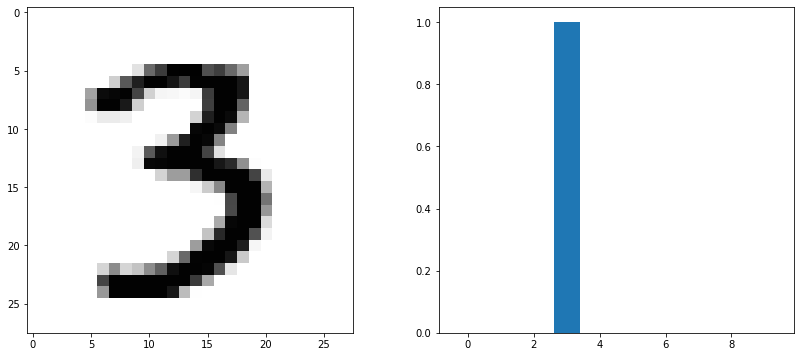

In [233]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
i = 10000
axs[0].imshow(1 - mnist['X_train'][i].reshape(28, 28), cmap="gray")
axs[1].bar(jnp.arange(10), jax.nn.softmax(mlp(*params_star, X[i])))

## Building more complicated NNets
In practice we don't code these by hand, but instead rely on other libraries that have implemented all the standard layers. PyTorch is very popular. I am partial to [Equinox](https://docs.kidger.site/equinox/all-of-equinox/), which is similar to PyTorch but easier to understand (has less magic).

In [237]:
import equinox as eqx
from jaxtyping import Float, Array

class CNN(eqx.Module):  # same as in PyTorch
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key2),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x

key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

In [238]:
eqx.filter_value_and_grad(model)(
    X[:1].reshape(-1, 28, 28)
)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (10,).